In [1]:
import pandas as pd
import glob
import os
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import operator
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import time
from sklearn.metrics import accuracy_score


from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


In [2]:
train_pos_path=r'C:\Users\Sharath Pujar\Desktop\DigitalVidhya\python_Datascience\materials\milestoneProject\aclImdb\train\pos\*.txt'
train_neg_path=r'C:\Users\Sharath Pujar\Desktop\DigitalVidhya\python_Datascience\materials\milestoneProject\aclImdb\train\neg\*.txt'
test_pos_path=r'C:\Users\Sharath Pujar\Desktop\DigitalVidhya\python_Datascience\materials\milestoneProject\aclImdb\test\pos\*.txt'
test_neg_path=r'C:\Users\Sharath Pujar\Desktop\DigitalVidhya\python_Datascience\materials\milestoneProject\aclImdb\test\neg\*.txt'


In [3]:
def data_preprocessing(path):
    files = glob.glob(path)
    data = pd.DataFrame()
    
    for file in files:
        row = {'UId':'','Rating':'','review': '','label':''}
        with open(file, 'r', encoding = 'iso-8859-1') as f:
            content = f.read()
            row['review'] = content
        id_rate=file.split('\\')[11]
        Uid,Rating=id_rate.split('.')[0].split('_')
        row['UId'] = Uid
        row['Rating'] = Rating
        
        label=file.split('\\')[10]
        if label=='pos':
            row['label']='1'
        else:
            row['label']='0'
            
        data = data.append(row, ignore_index = True)
            
    return data
    
    
    

In [4]:
data_train_pos=data_preprocessing(train_pos_path)
data_train_neg=data_preprocessing(train_neg_path)

data_test_pos=data_preprocessing(test_pos_path)
data_test_neg=data_preprocessing(test_neg_path)

In [5]:
data_train_neg=data_train_neg[['review','label']]
data_test_neg=data_test_neg[['review','label']]

In [6]:
imdb_train=pd.concat([data_train_pos,data_train_neg],ignore_index = True)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [7]:
imdb_test=pd.concat([data_test_pos,data_test_neg],ignore_index = True)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
def rem_sw(df):
    # Downloading stop words
    stop_words = set(stopwords.words('english'))

    # Removing Stop words from training data
    count = 0
    for sentence in df:
        sentence = [word for word in sentence.lower().split() if word not in stop_words]
        sentence = ' '.join(sentence)
        df.loc[count] = sentence
        count+=1
    return(df)

In [9]:
def rem_punc(df):
    count = 0
    for s in df:
        cleanr = re.compile('<.*?>')
        s = re.sub(r'\d+', '', s)
        s = re.sub(cleanr, '', s)
        s = re.sub("'", '', s)
        s = re.sub(r'\W+', ' ', s)
        s = s.replace('_', '')
        df.loc[count] = s
        count+=1
    return(df)

In [10]:
def lemma(df):

    lmtzr = WordNetLemmatizer()

    count = 0
    stemmed = []
    for sentence in df:    
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(lmtzr.lemmatize(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [11]:
def stemma(df):

    stemmer = SnowballStemmer("english") #SnowballStemmer("english", ignore_stopwords=True)

    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [12]:
def get_feature(df, number):
    
    feature_list = []
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)
    
    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]
    
    for f in range(number):
        feature_list.append(sorted_features[f][0])
    
    return(feature_list)



In [13]:
def print_feature(df):
    
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)

    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

In [14]:
def get_bestrf(X, y):
    parameters = [
        {
            "n_estimators":[5, 10, 20, 50, 100],
            "criterion":['gini', 'entropy']
        }
    ]

    best_clf = GridSearchCV(clf, parameters, scoring="accuracy", verbose=5, n_jobs=4)

    best_clf.fit(X, y)
    
    return(best_clf.best_estimator_.n_estimators, best_clf.best_estimator_.criterion)

In [15]:
imdb_train['review'] = rem_sw(imdb_train['review'])
imdb_test['review'] = rem_sw(imdb_test['review'])

imdb_train['review'] = rem_punc(imdb_train['review'])
imdb_test['review'] = rem_punc(imdb_test['review'])

imdb_train['review'] = lemma(imdb_train['review'])
imdb_train['review'] = stemma(imdb_train['review'])


imdb_test['review'] = lemma(imdb_test['review'])
imdb_test['review'] = stemma(imdb_test['review'])


#print_feature(imdb_train)

Feature ranking:
feature 3036 : bad (0.008553)
feature 49132 : wast (0.006895)
feature 50231 : worst (0.006002)
feature 18324 : great (0.005329)
feature 2822 : aw (0.004215)
feature 14477 : excel (0.003715)
feature 34662 : poor (0.003191)
feature 44694 : terribl (0.003160)
feature 33614 : perfect (0.003138)
feature 43164 : stupid (0.003107)
feature 5228 : bore (0.003096)
feature 26382 : love (0.002857)
feature 31341 : noth (0.002772)
feature 20667 : horribl (0.002433)
feature 43605 : suppos (0.002385)
feature 13877 : enjoy (0.002300)
feature 4180 : best (0.002238)
feature 50223 : wors (0.002231)
feature 9724 : crap (0.002189)
feature 15088 : favorit (0.001982)


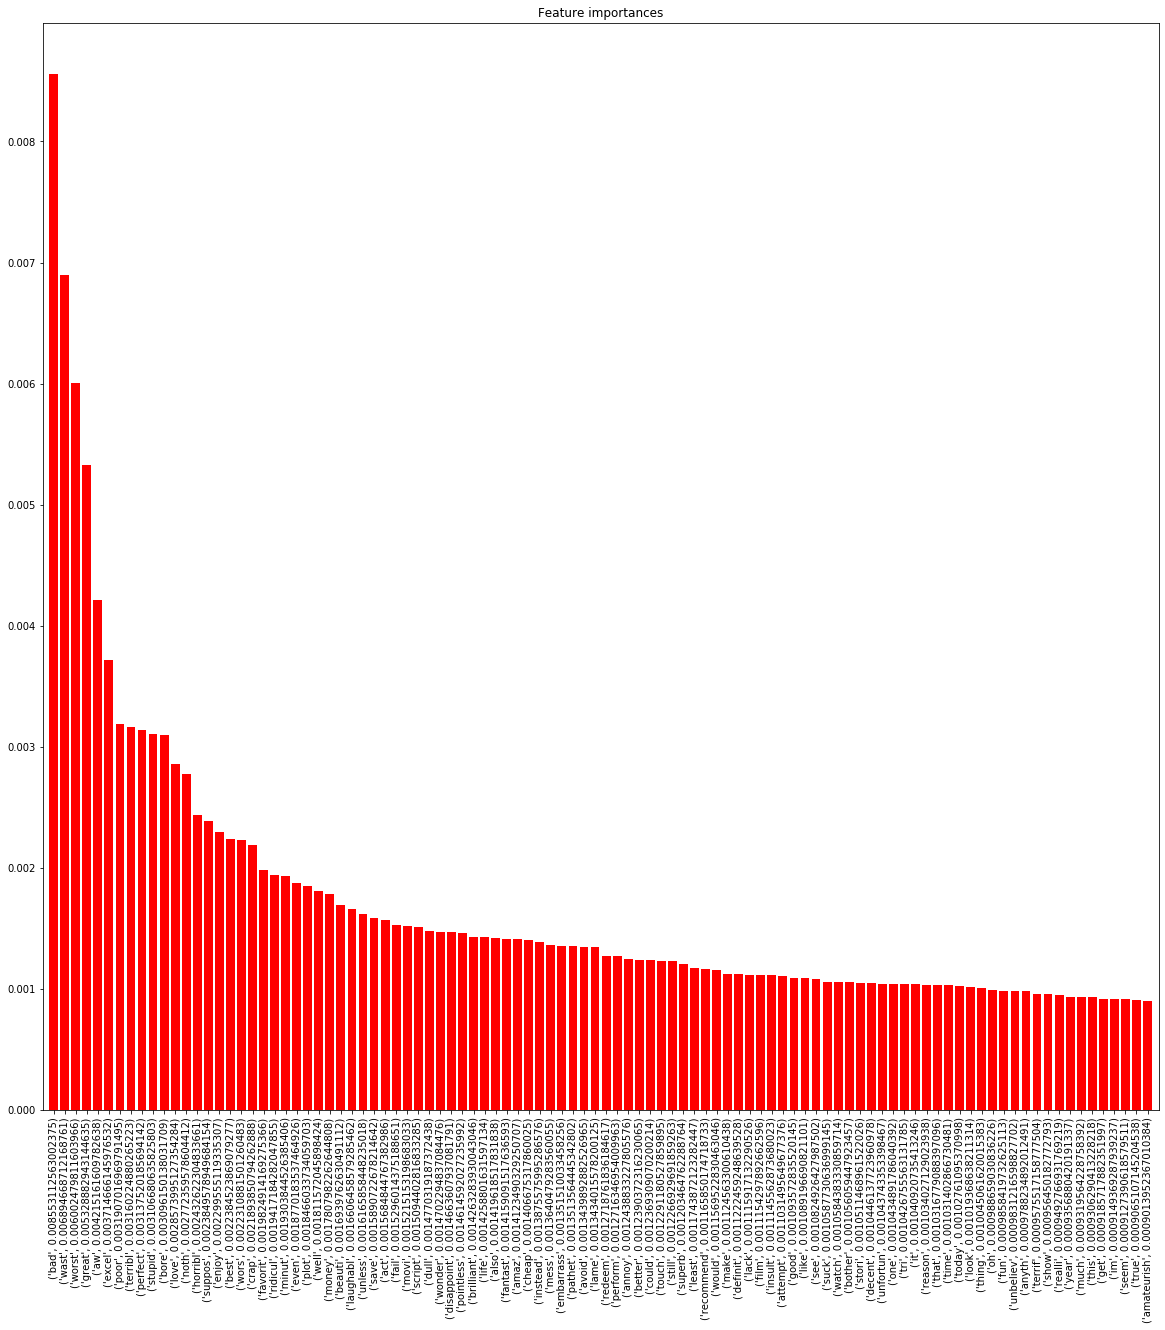

()

In [16]:
print_feature(imdb_train)

Feature ranking:
feature 2998 : bad (0.007887)
feature 48633 : wast (0.007402)
feature 49762 : worst (0.006792)
feature 18403 : great (0.005091)
feature 34350 : poor (0.004026)
feature 44217 : terribl (0.003871)
feature 2792 : aw (0.003616)
feature 14537 : excel (0.003425)
feature 49757 : wors (0.003099)
feature 5115 : bore (0.003062)
feature 26200 : love (0.002728)
feature 4123 : best (0.002670)
feature 20653 : horribl (0.002546)
feature 43110 : suppos (0.002519)
feature 31019 : noth (0.002519)
feature 5627 : brilliant (0.002503)
feature 42692 : stupid (0.002483)
feature 13953 : enjoy (0.002350)
feature 14431 : even (0.002090)
feature 33262 : perfect (0.002034)


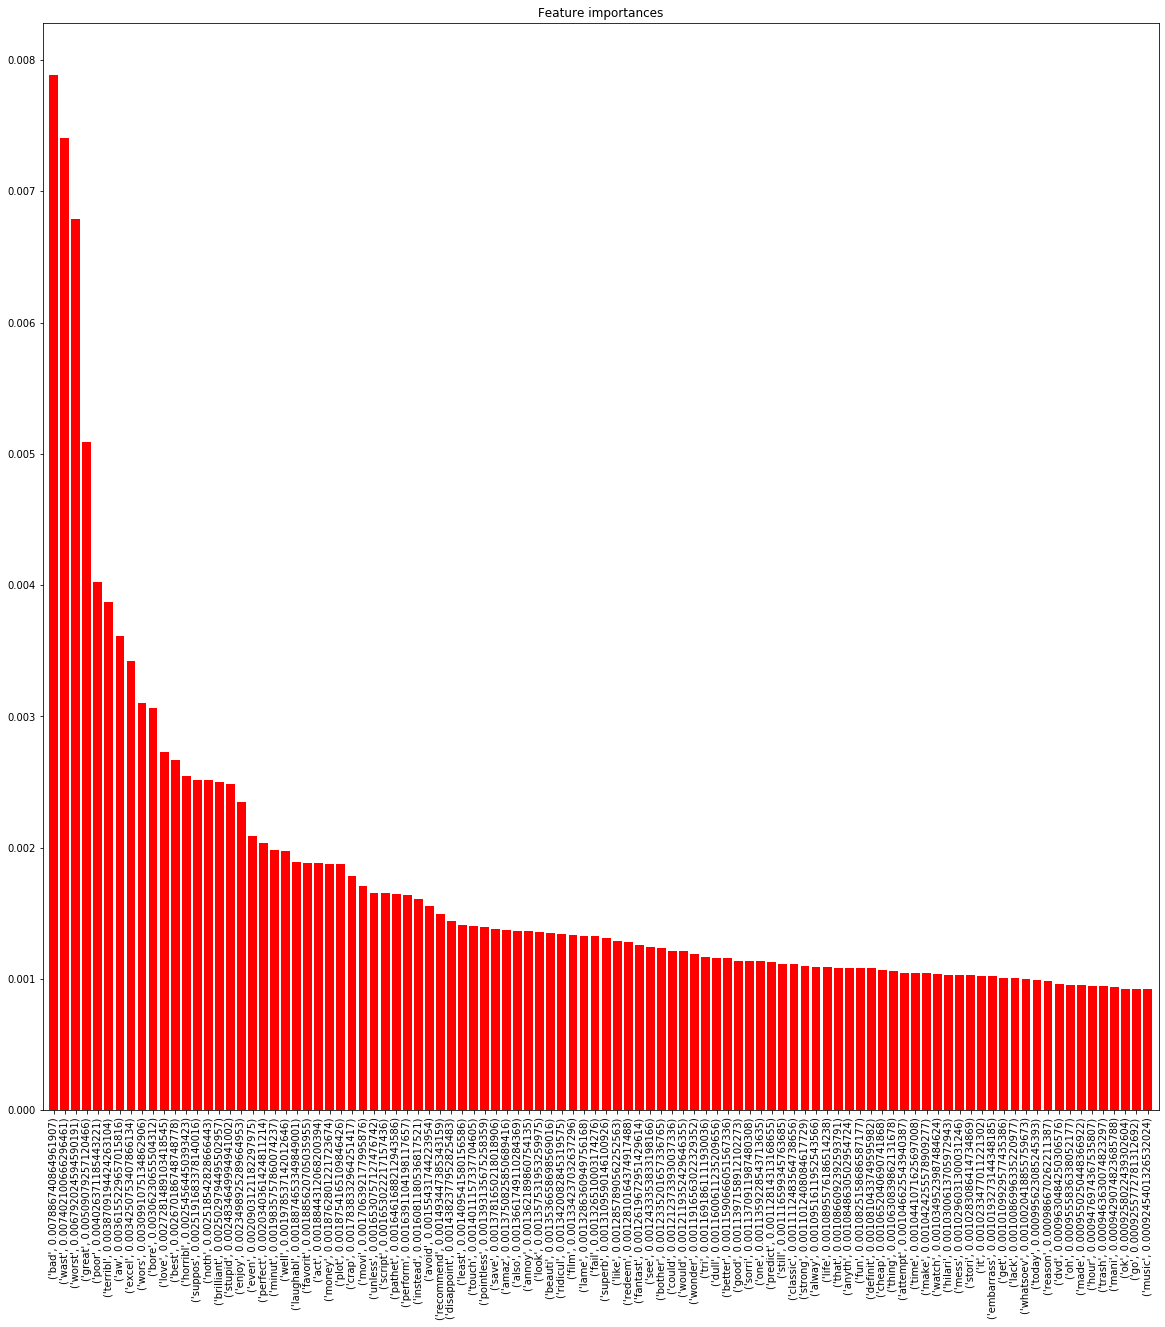

()

In [17]:
print_feature(imdb_test)

In [18]:
# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing negative reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq[df_freq.label.isin(['0'])].review)

# Visualising the high frequency words for negative set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
movi,58387
film,44962
like,24640
make,16205
bad,15847
time,15317
watch,14965
good,14918
charact,14319
realli,12353


In [19]:

# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing pos reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq[df_freq.label.isin(['1'])].review)

# Visualising the high frequency words for positive set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
film,50860
movi,44822
like,20554
time,16619
good,15261
stori,14180
charact,14017
make,13807
great,13334
watch,12905


In [20]:
# Creating a frequency dataframe of stemmed train and test data set
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Vectorizing complete review set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_freq.review)

# Visualising the high and low frequency words for complete set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
print(df_freq.nlargest(1, 'frequency'), sep='\n')
print(df_freq.nsmallest(1, 'frequency'), sep='\t')

      frequency
movi     103209
                            frequency
aaaaaaaaaaaahhhhhhhhhhhhhh          1


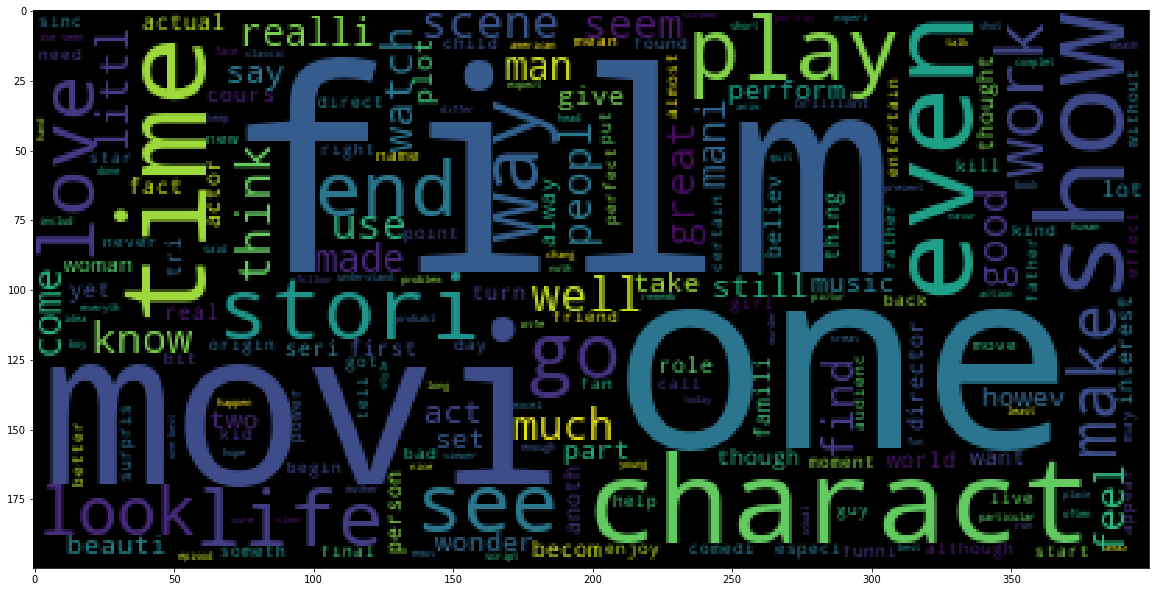

In [21]:
########################## WordCloud Positive Train & Test set ##################################

# Creating a list of train and test data to analyse
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)
imdb_list = df_freq["review"][df_freq.label.isin(['1'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

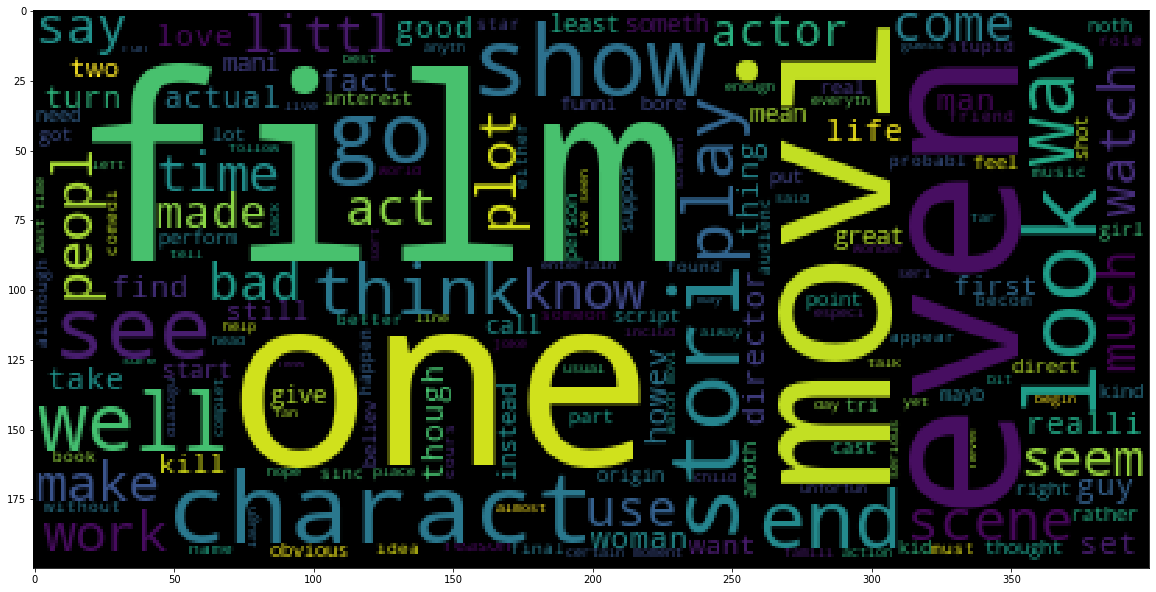

In [22]:
########################## WordCloud Negative Train & Test set ##################################

# Creating a list of train and test data to analyse
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)
imdb_list = df_freq["review"][df_freq.label.isin(['0'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for negative words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

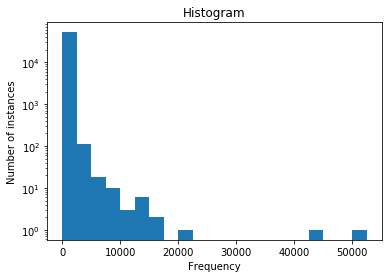

In [23]:

#Combining cleaned train and test data
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_freq[df_freq.label.isin(['1'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data[0], bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

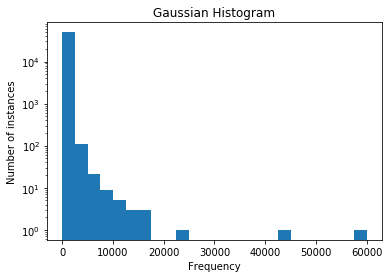

In [24]:
########################## Histogram Negative Train & Test set ##################################

#Combining cleaned train and test data
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_neg = hist_cv.fit_transform(df_freq[df_freq.label.isin(['0'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_neg.sum(axis=0).tolist()
binwidth = 2500
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Gaussian Histogram")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

In [25]:
df_freq = pd.concat([imdb_train, imdb_test], ignore_index = True)

word_list = get_feature(df_freq, 1000)

# Removing non prefered words from training and test combined data
count = 0
for sentence in df_freq['review']:
    sentence = [word for word in sentence.lower().split() if word in word_list]
    sentence = ' '.join(sentence)
    df_freq.loc[count, 'review'] = sentence
    count+=1


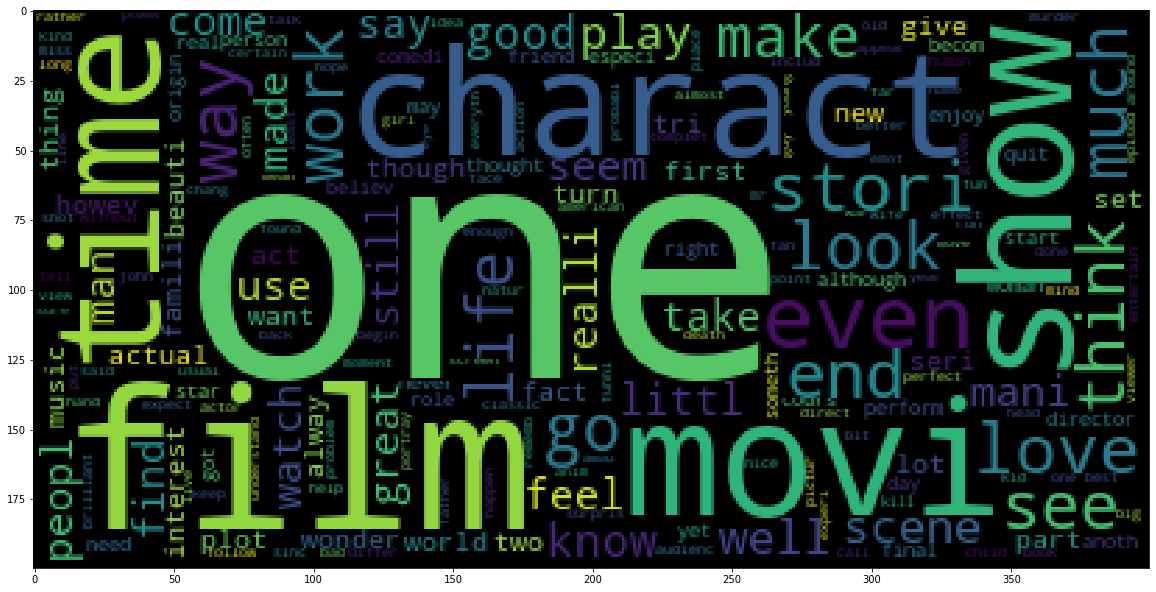

In [26]:
########################## WordCloud Positive Train & Test set post feature selection ##################################

# Creating a list of train and test data to analyse
imdb_list = df_freq["review"][df_freq.label.isin(['1'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

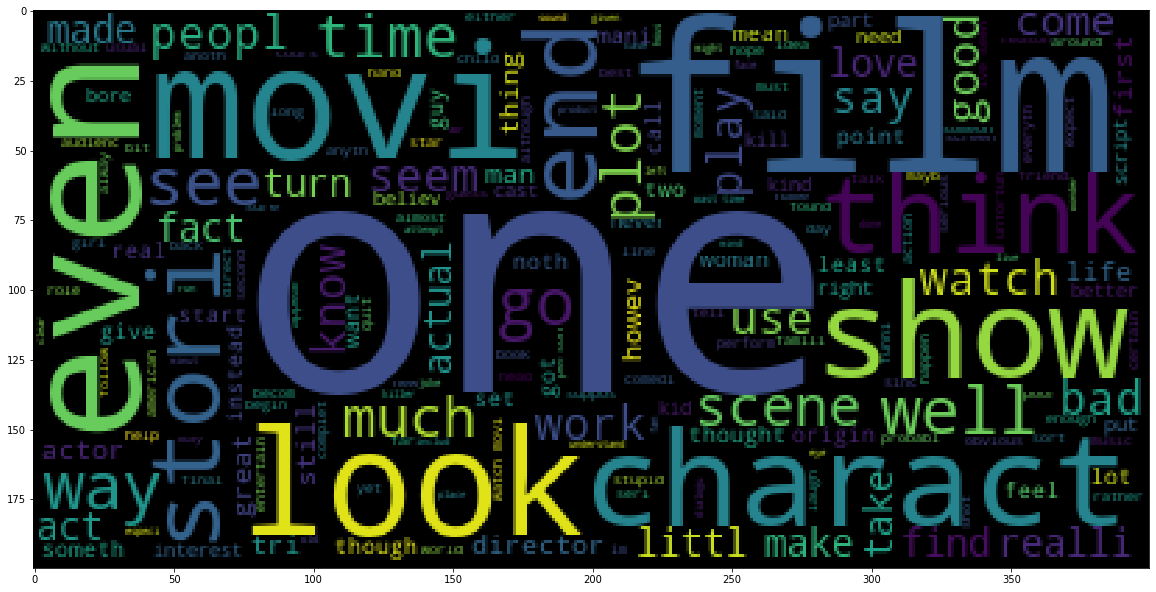

In [27]:
########################## WordCloud Negative Train & Test set post feature selection ##################################

# Creating a list of ham data only to analyse
imdb_list = df_freq["review"][df_freq.label.isin(['0'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for ham
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

In [28]:
imdb_train.shape

(25000, 4)

In [29]:
imdb_test.shape

(25000, 4)

In [30]:
df_freq.shape

(50000, 4)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df_freq['review'])

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics


# splitting data into training and validation set
xtrain, xtest, ytrain, ytest = train_test_split(tfidf, df_freq['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain, ytrain)
ypred=lreg.predict(xtest)

print( metrics.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      7443
           1       0.87      0.89      0.88      7557

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



In [33]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(xtrain, ytrain)
predicted = model.predict(xtest)
print( metrics.classification_report(ytest, predicted))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      7443
           1       0.84      0.84      0.84      7557

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



In [34]:
clf = MultinomialNB()
clf.fit(xtrain, ytrain)

# predict the outcome for testing data
predicted = clf.predict(xtest)

# check the accuracy of the model
accuracy = accuracy_score(ytest, predicted)
print("Observation: Naive Bayes Classification gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: Naive Bayes Classification gives an accuracy of 85.67% on the testing data


In [35]:
unsup_path=r'C:\Users\Sharath Pujar\Desktop\DigitalVidhya\python_Datascience\materials\milestoneProject\aclImdb\train\unsup\*.txt'

In [36]:
def data_preprocessing(path):
    files = glob.glob(path)
    data = pd.DataFrame()
    
    for file in files:
        row = {'review': ''}
        with open(file, 'r', encoding = 'iso-8859-1') as f:
            content = f.read()
            row['review'] = content

            
        data = data.append(row, ignore_index = True)
            
    return data

In [37]:
unsup_data=data_preprocessing(unsup_path)

In [38]:
imdb_unsup=unsup_data.copy()

In [39]:
unsup_data.head()

,review
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."


In [40]:
imdb_unsup.head()

,review
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."


In [41]:
unsup_data['review'] = rem_sw(unsup_data['review'])

unsup_data['review'] = rem_punc(unsup_data['review'])


unsup_data['review'] = lemma(unsup_data['review'])



unsup_data['review'] = stemma(unsup_data['review'])


In [42]:
unsup_data.head()

,review
0,admit great major film releas say me dozen maj...
1,take low budget inexperienc actor doubl produc...
2,everybodi seen back futur right whether like m...
3,dori day icon beauti sing act warm voic genius...
4,seri silli fun love movi big year dori day yea...


In [43]:
# word_list = get_feature(unsup_data['review'], 14440)

# # Removing non prefered words from training and test combined data
# count = 0
# for sentence in unsup_data['review']:
#     sentence = [word for word in sentence.lower().split() if word in word_list]
#     sentence = ' '.join(sentence)
#     unsup_data.loc[count, 'review'] = sentence
#     count+=1


In [44]:
#count

In [45]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(unsup_data.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
 
# Visualising the 2 clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 movi
 like
 watch
 bad
 good
 realli
 time
 make
 film
 act
Cluster 1:
 film
 movi
 like
 charact
 time
 stori
 good
 make
 watch
 great


In [46]:
Y = vectorizer.transform(unsup_data.review)
prediction = model.predict(Y)
prediction

array([1, 1, 0, ..., 0, 0, 1])

In [47]:
#selecting some of the features

In [48]:
imdb_unsup['review'] = rem_sw(imdb_unsup['review'])
imdb_unsup['review'] = rem_punc(imdb_unsup['review'])
imdb_unsup['review'] = lemma(imdb_unsup['review'])
imdb_unsup['review'] = stemma(imdb_unsup['review'])

# Vectorizing unlabelled reviews set
vect = CountVectorizer(analyzer='word')
vect_pos = vect.fit_transform(imdb_unsup.review)

# Creating a dataframe for the high frequency words for unlabelled reviews set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T

# Removing high frequency and low frequency data for more accuracy

word_list = df_freq.nlargest(100, 'frequency').index
word_list = word_list.append(df_freq.nsmallest(43750, 'frequency').index)

# Removing unwanted words based on word_list from unlabelled data
count = 0
for sentence in imdb_unsup['review']:
    sentence = [word for word in sentence.lower().split() if word not in word_list]
    sentence = ' '.join(sentence)
    imdb_unsup.loc[count, 'review'] = sentence
    count+=1
    
##################################### Using K-means to create clusters ##################################### 

# Vectorizing dataset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(imdb_unsup.review)
 
# Creating a k-means object and fitting it to target variable
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=13)
model.fit(X)
 
# Visualising the clusters
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 music
 origin
 wonder
 fan
 john
 fun
 excel
 big
 saw
 quit
Cluster 1:
 book
 read
 novel
 adapt
 version
 chang
 base
 origin
 seri
 disappoint
Cluster 2:
 comedi
 laugh
 joke
 romant
 humor
 hilari
 grant
 fun
 sandler
 expect
Cluster 3:
 horror
 zombi
 gore
 dead
 scari
 effect
 kill
 flick
 slasher
 budget
Cluster 4:
 war
 famili
 american
 person
 beauti
 child
 young
 human
 emot
 live
Cluster 5:
 episod
 seri
 game
 season
 tv
 fan
 origin
 dvd
 televis
 ive
Cluster 6:
 worst
 wast
 minut
 bore
 terribl
 poor
 ive
 script
 aw
 money
Cluster 7:
 kid
 child
 famili
 adult
 parent
 school
 boy
 saw
 rememb
 laugh
Cluster 8:
 anim
 cartoon
 disney
 bambi
 voic
 origin
 seri
 music
 short
 child


In [49]:
 Review="Old man Eastwood mixed action, drama and humor in a way only a legendary filmmaker could put together. The man still has the ability to tell a compelling story"
# Genre Search in review-  action, drama and humor

In [59]:
vectorizer = TfidfVectorizer(stop_words='english')
y = vectorizer.fit_transform(Review.split(' '))

In [66]:
prediction = model.fit_predict(y)
terms=vectorizer.get_feature_names()

terms

['ability',
 'action',
 'compelling',
 'drama',
 'eastwood',
 'filmmaker',
 'humor',
 'legendary',
 'man',
 'mixed',
 'old',
 'story',
 'tell',
 'way']

In [84]:
prediction

array([8, 2, 1, 1, 1, 1, 1, 4, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 0, 1, 6, 1, 3, 7])

In [ ]:
#